In [1]:
## Pacotes para abrir arquivos em pastas:
import os
import glob
import warnings
warnings.filterwarnings('ignore')

## Pacotes para arrumar os dados:
from scipy.optimize import curve_fit,least_squares
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
%matplotlib inline

In [2]:
### Função para fazer o ajuste linear com o Modelo de Regressão Linear do Scikit-Learn:
def ajuste_linear_sklearn(X_feature, y_target):
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=True)
    X_feature = X_feature.reshape(-1,1)
    reg.fit(X_feature, y_target)
    y_modelado = reg.predict(X_feature)
    m = reg.coef_[0]
    b = reg.intercept_
    R2_score = reg.score(X_feature, y_target)
    return y_modelado, m, b, R2_score

In [3]:
### Listando os arquivos .pkl construídos de nuvens (intervalo de amostragem original, igual a 1 seg):
pasta_selecao = '/media/andre/SAMSUNG/03_HD_500GB_WD/G1_Micael/Dataframes_construidos2/'
arquivos = sorted(glob.glob(pasta_selecao+'Nuvens?????????2014_1seg.pkl'))

### Lendo os .pkl de cada dia com o pandas (como dataframes) e guardando eles na lista dfs:
dfs = [pd.read_pickle(a) for a in arquivos]

In [4]:
### Filtrando os pontos em que gotas de nuvem foram detectadas, ou seja, pontos nos quais há nuvens:
dfs_com_nuvem = []
for i in range(len(dfs)):
    filtro1 = dfs[i][(dfs[i]['conc(#_L)']>0.0000000000) & (dfs[i]['LWC_083']>0.0) & (dfs[i]['LWC_021']>0.0)]
    dfs_com_nuvem.append(filtro1)

In [5]:
dfs_liquidas = []
for i in range(len(dfs_com_nuvem)):
    iwc = dfs_com_nuvem[i]['TWC']-dfs_com_nuvem[i]['LWC_083']
#     iwc = dfs_com_nuvem[i]['TWC']-dfs_com_nuvem[i]['LWC_021']
    linhas_excluir = []
    for j in range(len(iwc)):
        ### Se iwc > 0, tem gelo na nuvem:
        if iwc[j] > 0:
            linhas_excluir.append(j)
    liquida = dfs_com_nuvem[i].drop(dfs_com_nuvem[i].index[linhas_excluir])
    dfs_liquidas.append(liquida)

In [6]:
### Função que calcula os reffs pela razão das integrais, onde cada r é a média dos limites de cada bin de tam:
def reffs_pelas_integrais(d):
    #################################################################################################
    # Pegando só as colunas com as concentrações numéricas de gotas nos bins de raio efetivo da gota:
    colsc = list(d.columns)[12:-1]
    r0s, r1s = [], []
    for n in colsc:
        r0 = n.split(':')[1].split('-')[0]
        r0s.append(float(r0))
        r1 = n.split(':')[1].split('-')[1]
        r1s.append(float(r1))
    rmedios, rmediosquadrado, rmedioscubo = [], [], []
    for i in range(len(r0s)):
        rmedio = (r0s[i]+r1s[i])/2
        rmedios.append(rmedio)
        rmediosquadrado.append(rmedio**2)
        rmedioscubo.append(rmedio**3)
    ###################################################################################################
    diccubo, dicquadrado = {}, {}
    for i in range(len(colsc)):
        diccubo.update({rmedios[i]:rmedioscubo[i]*d[colsc[i]]})
        dicquadrado.update({rmedios[i]:rmediosquadrado[i]*d[colsc[i]]})
    dfcubo = pd.DataFrame(diccubo)
    dfquadrado = pd.DataFrame(dicquadrado)
    reffs = []
    for t in range(len(dfquadrado)):
        reffs.append(np.sum(dfcubo.iloc[t])/np.sum(dfquadrado.iloc[t]))
    return reffs

In [7]:
################################ CHAMANDO A FUNÇÃO: 
integrais2 = [reffs_pelas_integrais(i) for i in dfs_liquidas]

In [8]:
for i in range(len(dfs_liquidas)):
    dfs_liquidas[i].insert(33, "reff_int", integrais2[i], True)

In [9]:
lwc083_iop1, reff_integrais2_iop1 = [], []
for i in np.arange(0, 13, 1):
    for v1 in dfs_liquidas[i]['LWC_083'].values:
#     for v1 in dfs_liquidas[i]['LWC_021'].values:
        lwc083_iop1.append(v1)
    for v2 in dfs_liquidas[i]['reff_int'].values:
        reff_integrais2_iop1.append(v2)
        
lwc083_iop2, reff_integrais2_iop2 = [], []
for ii in np.arange(13, 32, 1):
    for v11 in dfs_liquidas[ii]['LWC_083'].values:
#     for v11 in dfs_liquidas[ii]['LWC_021'].values:
        lwc083_iop2.append(v11)
    for v22 in dfs_liquidas[ii]['reff_int'].values:
        reff_integrais2_iop2.append(v22)

In [10]:
#################################################

In [11]:
### Filtros Micael (1° artigo):
dfs_filtros_lwc = []
for i in range(len(dfs_liquidas)):
    fil = dfs_liquidas[i][(dfs_liquidas[i]['LWC_083']>=0.02) & ((dfs_liquidas[i]['conc(#_L)']/1000)>0.3)]
    dfs_filtros_lwc.append(fil)

In [12]:
#############################################################

In [13]:
# ratios = []
for i in range(len(dfs_filtros_lwc)):
    N = dfs_filtros_lwc[i]['conc(#_L)']*1000
    ratio = dfs_filtros_lwc[i]['LWC_083']/N
    dfs_filtros_lwc[i].insert(34, "ratio(g)", ratio, True)
#     ratios.append(ratio)

In [14]:
ratio_iop1, reff_integrais2_iop1 = [], []
for i in np.arange(0, 13, 1):
    for v1 in dfs_filtros_lwc[i]['ratio(g)'].values:
        ratio_iop1.append(v1)
    for v2 in dfs_filtros_lwc[i]['reff_int'].values:
        reff_integrais2_iop1.append(v2)
        
ratio_iop2, reff_integrais2_iop2 = [], []
for ii in np.arange(13, 32, 1):
    for v11 in dfs_filtros_lwc[ii]['ratio(g)'].values:
        ratio_iop2.append(v11)
    for v22 in dfs_filtros_lwc[ii]['reff_int'].values:
        reff_integrais2_iop2.append(v22)

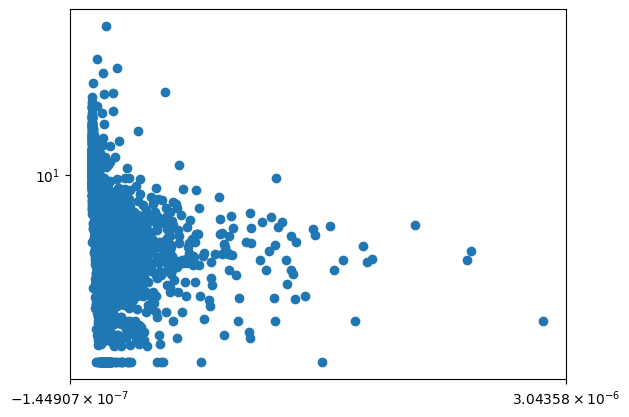

In [15]:
plt.yscale('symlog')
plt.xscale('symlog')
plt.scatter(ratio_iop2, reff_integrais2_iop2)

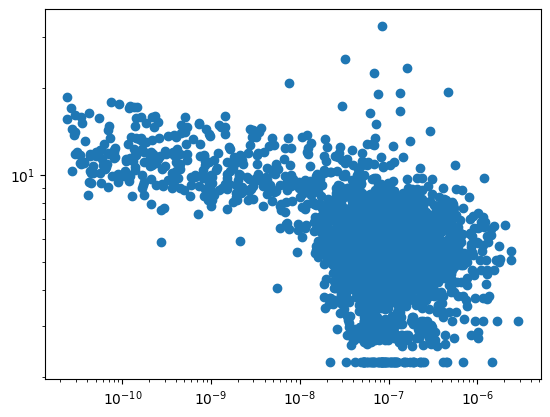

In [16]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(ratio_iop2, reff_integrais2_iop2)

In [17]:
#############################################################

In [18]:
for i in range(len(dfs_filtros_lwc)):
    N_cm3 = dfs_filtros_lwc[i]['conc(#_L)']/1000
    razao = dfs_filtros_lwc[i]['LWC_083']/N_cm3
    reff_reid17 = (6.67)*(razao**(0.31))
    reff_reid18 = (7.50)*(razao**(0.33))
    dfs_filtros_lwc[i].insert(35, "reff_reid17", reff_reid17, True)
    dfs_filtros_lwc[i].insert(36, "reff_reid18", reff_reid18, True)

In [19]:
dfs_filtros_lwc[0]

,UTC,pts_tempo,Lat,Lon,GPS_Alt,PSAP_ABS_522nm,NEPH_TS_550nm,NEPH_BS_550nm,TWC,LWC_083,...,C:33-36,C:36-39,C:39-42,C:42-46,C:46-50,C:50-150,reff_int,ratio(g),reff_reid17,reff_reid18
time,,,,,,,,,,,,,,,,,,,,,
2014-02-22 14:37:56,14:37:56,52676,-3.03817,-60.0195,354.0,7.054290,20.431700,2.965970,0.013742,0.024338,...,0.00,0.0000,0.0,0.0,0.0000,0.0,7.743312,7.887786e-08,3.035162,3.243818
2014-02-22 14:38:14,14:38:14,52694,-3.03783,-60.0063,466.0,4.972600,17.826000,3.019390,0.009281,0.021793,...,0.00,0.0000,0.0,0.0,0.0000,0.0,10.169750,5.961740e-08,2.782861,2.957565
2014-02-22 14:38:46,14:38:46,52726,-3.03683,-59.9825,649.0,1.237840,14.727800,2.175060,0.009674,0.021268,...,0.00,0.0000,0.0,0.0,0.0000,0.0,7.456976,8.684249e-10,0.750124,0.732560
2014-02-22 14:38:50,14:38:50,52730,-3.03667,-59.9795,650.0,1.594910,15.559200,2.205540,0.010945,0.020288,...,0.00,0.0000,0.0,0.0,0.0000,0.0,5.770681,3.764245e-08,2.413159,2.541177
2014-02-22 14:39:00,14:39:00,52740,-3.03633,-59.9722,662.0,1.551320,14.068000,2.098030,0.012751,0.024739,...,0.00,0.0000,0.0,0.0,0.0000,0.0,7.648917,8.023507e-08,3.051257,3.262132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-22 16:39:08,16:39:08,59948,-2.70933,-60.4820,2488.0,0.295438,0.413787,-0.344482,0.035604,0.041868,...,0.00,0.0000,0.0,0.0,0.0000,0.0,16.523514,3.121552e-09,1.115272,1.117387
2014-02-22 16:39:09,16:39:09,59949,-2.70967,-60.4812,2493.0,0.013099,0.488291,-0.400554,0.015682,0.026355,...,0.00,0.0000,0.0,0.0,0.0000,0.0,13.750508,1.482169e-09,0.885328,0.873892
2014-02-22 16:39:10,16:39:10,59950,-2.70983,-60.4805,2498.0,-0.147951,0.429397,-0.435536,0.021834,0.024735,...,0.00,0.0000,0.0,0.0,0.0000,0.0,14.557755,2.281195e-09,1.011943,1.007523


In [20]:
### Na lista "dfs_filtros_lwc" estão os dfs dos 2 IOP's. Aqui pego só os do IOP2 e coloco na lista "dfs_iop2":
dfs_iop2 = []
for i in np.arange(13, 32, 1):
    dfs_iop2.append(dfs_filtros_lwc[i])
len(dfs_iop2)

19

In [21]:
dfs_iop2[0]

,UTC,pts_tempo,Lat,Lon,GPS_Alt,PSAP_ABS_522nm,NEPH_TS_550nm,NEPH_BS_550nm,TWC,LWC_083,...,C:33-36,C:36-39,C:39-42,C:42-46,C:46-50,C:50-150,reff_int,ratio(g),reff_reid17,reff_reid18
time,,,,,,,,,,,,,,,,,,,,,
2014-09-06 17:03:15,17:03:15,61395,-2.91467,-60.3160,1615.0,7.48948,54.4209,6.69645,0.022180,0.022400,...,0.0,0.0,0.0,0.0,0.0,0.0,9.382232,4.437623e-11,0.298361,0.274550
2014-09-06 17:16:39,17:16:39,62199,-3.45500,-60.5377,1599.0,6.54775,44.7722,5.49808,0.091421,0.108051,...,0.0,0.0,0.0,0.0,0.0,0.0,9.562683,3.492682e-09,1.154796,1.159588
2014-09-06 17:16:40,17:16:40,62200,-3.45483,-60.5387,1598.0,6.57009,44.3487,5.38009,0.072205,0.086400,...,0.0,0.0,0.0,0.0,0.0,0.0,9.856413,6.742639e-09,1.416000,1.440705
2014-09-06 17:16:41,17:16:41,62201,-3.45450,-60.5397,1598.0,6.58277,44.0744,5.19842,0.057134,0.074275,...,0.0,0.0,0.0,0.0,0.0,0.0,7.704297,1.064447e-08,1.631302,1.674990
2014-09-06 17:16:42,17:16:42,62202,-3.45433,-60.5407,1598.0,6.51491,44.1103,5.07299,0.027780,0.050667,...,0.0,0.0,0.0,0.0,0.0,0.0,6.861794,1.076037e-07,3.341891,3.593886
2014-09-06 17:16:44,17:16:44,62204,-3.45400,-60.5425,1598.0,6.37958,45.0565,5.11453,0.017448,0.029586,...,0.0,0.0,0.0,0.0,0.0,0.0,8.842852,7.126316e-08,2.941129,3.136944
2014-09-06 17:16:45,17:16:45,62205,-3.45383,-60.5435,1598.0,6.51480,45.5036,5.20281,0.013249,0.021746,...,0.0,0.0,0.0,0.0,0.0,0.0,5.123113,7.208414e-08,2.951591,3.148824
2014-09-06 17:23:29,17:23:29,62609,-3.09017,-60.6128,1591.0,12.42170,65.9556,7.76090,0.015875,0.025585,...,0.0,0.0,0.0,0.0,0.0,0.0,6.509038,7.235547e-08,2.955030,3.152730
2014-09-06 17:23:30,17:23:30,62610,-3.08933,-60.6130,1592.0,12.60590,66.0680,7.57682,0.011552,0.021303,...,0.0,0.0,0.0,0.0,0.0,0.0,5.205465,6.817101e-08,2.900960,3.091357


In [22]:
### Concatenando (para cada dia do IOP2) as listas de reff 17 e reff 18, assim como a lista de lwcs com ela
### mesma:
refs_n_iop2, lwcs_n_iop2 = [], []
for n in range(len(dfs_iop2)):
    refs_n = list(dfs_iop2[n]['reff_reid17'])+list(dfs_iop2[n]['reff_reid18'])
    lwcs_n = list(dfs_iop2[n]['LWC_083'])*2
    refs_n_iop2.append(refs_n)
    lwcs_n_iop2.append(lwcs_n)

In [23]:
lwcs_n_iop2[0]

[0.0224001,
 0.108051,
 0.0863995,
 0.0742749,
 0.0506666,
 0.0295859,
 0.0217462,
 0.0255854,
 0.0213031,
 0.0249665,
 0.0204249,
 0.0224001,
 0.108051,
 0.0863995,
 0.0742749,
 0.0506666,
 0.0295859,
 0.0217462,
 0.0255854,
 0.0213031,
 0.0249665,
 0.0204249]

In [24]:
### Construindo uma lista gigante com todos os reffs (calculados pelas equações 17 E 18) e lwcs de todos os dias
### da IOP 2:
refs_iop2, lwcs_iop2 = [], []
for n in np.arange(len(refs_n_iop2)):
    refs_iop2 = refs_iop2+refs_n_iop2[n]
    lwcs_iop2 = lwcs_iop2+lwcs_n_iop2[n]

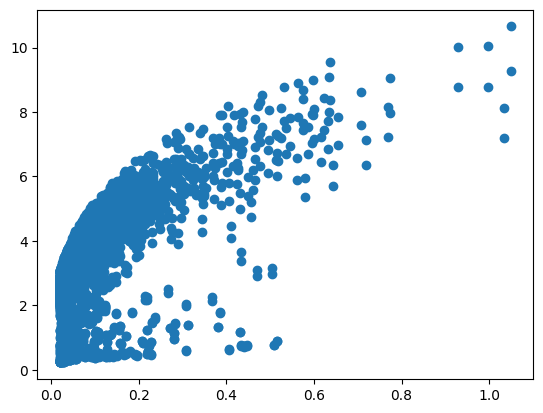

In [25]:
plt.scatter(lwcs_iop2, refs_iop2)

<AxesSubplot: >

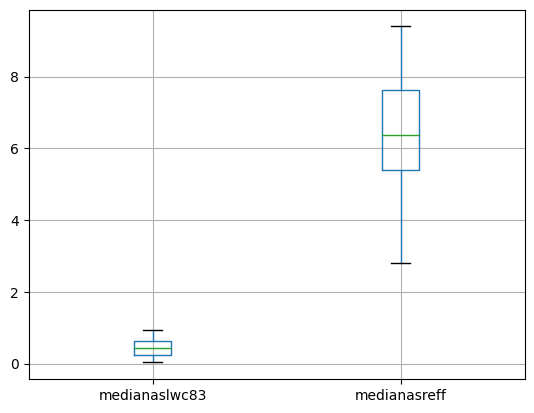

In [26]:
################ Medianas nos bins de LWC83 IOP2:
binslwc = np.arange(0.02, 1.02, 0.05)
# binslwc = np.arange(0.2, 1.05, 0.04)
# binslwc = np.arange(0.255, 0.315, 0.001)

dic = {'lwc83':lwcs_iop2 ,'reff':refs_iop2}
iop2 = pd.DataFrame(dic)

medianas_lwc, medianas_reff = [], []
for i in range(len(binslwc)-1):
    if i == len(binslwc)-3:
        faixa = iop2[(iop2['lwc83']>=binslwc[i]) & (iop2['lwc83']<=binslwc[i+1])]
        medianas_lwc.append(faixa.describe()['lwc83'][5])
        medianas_reff.append(faixa.describe()['reff'][5])
    else:
        faixa = iop2[(iop2['lwc83']>=binslwc[i]) & (iop2['lwc83']<binslwc[i+1])]
        medianas_lwc.append(faixa.describe()['lwc83'][5])
        medianas_reff.append(faixa.describe()['reff'][5])
        
dic_medianas = {'medianaslwc83':medianas_lwc, 'medianasreff':medianas_reff}
medianas_iop2 = pd.DataFrame(dic_medianas)
medianas_iop2.dropna(how='any', inplace=True)
# medianas_iop2

medianas_iop2.boxplot()

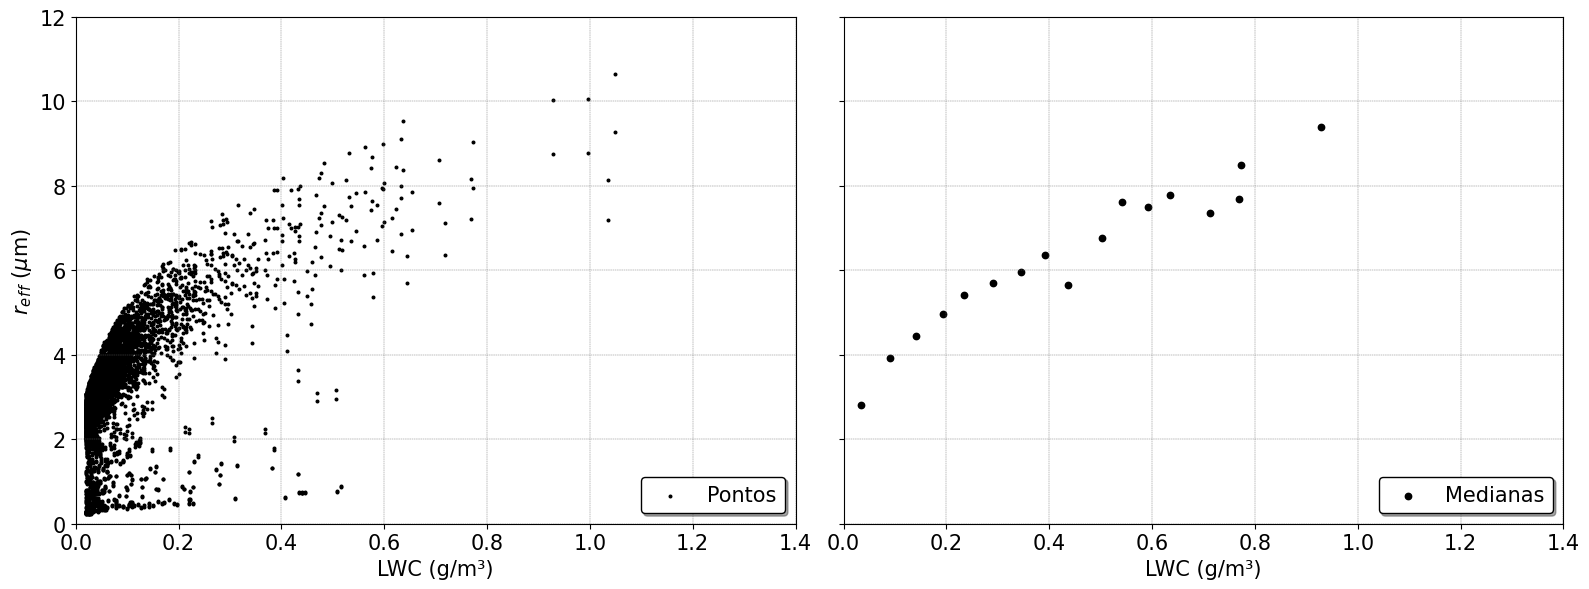

In [29]:
#### Fazendo a figura e os eixos (os "axs"):
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6), facecolor='white')
axes = [axs[0], axs[1]]
tf = 15

for i in range(len(axes)):
    plt.setp(axes[i].get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[i].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
    axes[i].grid(b=True, which='both', axis='both', color='dimgray', linestyle='--', linewidth=0.3)
    axes[i].set(xlim=[0, 1.4], ylim=[0, 12], facecolor='white')
#     axes[i].xaxis.set_major_locator(ticker.MultipleLocator(200))
#     axes[i].yaxis.set_major_locator(ticker.MultipleLocator(200))

    if i == 0:
#         axes[i].set_title('IOP 2', fontsize=tf+1, color='black')
        axes[i].set_ylabel(u'$r_e$$_f$$_f$ ($\mu$m)', fontsize=tf, color='black')
        axes[i].set_xlabel(u'LWC (g/m³)', fontsize=tf, color='black')
        axes[i].scatter(lwcs_iop2, refs_iop2, color='black', s=3.5, label='Pontos')
        axes[i].legend(loc='lower right', ncol=1, fontsize=tf, fancybox='True', shadow='True',
                       facecolor='white', edgecolor='black')
        axes[i].tick_params(labelsize=tf)
    if i == 1:
#         axes[i].set_title('IOP 2', fontsize=tf+1, color='black')
        axes[i].set_xlabel(u'LWC (g/m³)', fontsize=tf, color='black')
        x = np.array(medianas_iop2['medianaslwc83'])
        y = np.array(medianas_iop2['medianasreff'])
        y_ajustado, m, b, R2 = ajuste_linear_sklearn(x, y)
        axes[i].scatter(x, y, color='black', s=21, label='Medianas')
#         axes[i].plot(x, y_ajustado, color='red', linewidth=2, 
#                      label=u'y(x) = {:.2f}x{:+.2f}; (R²={:.2f})'.format(m,b,R2))
        axes[i].legend(loc='lower right', ncol=1, fontsize=tf, fancybox='True', shadow='True',
                       facecolor='white', edgecolor='black')
        axes[i].tick_params(labelsize=tf)
    
plt.tight_layout()
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Dispersão_LWCXreff_Reid17e18_IOP2.png', 
#             dpi=400, bbox_inches='tight', facecolor='white')

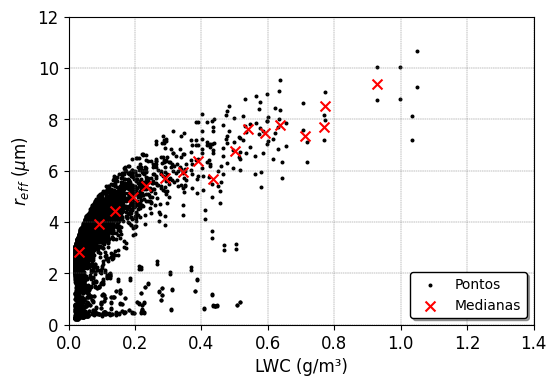

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
tf = 12
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')

ax.grid(b=True, which='both', axis='both', color='dimgray', linestyle='--', linewidth=0.3)
ax.set(xlim=[0, 1.4], ylim=[0, 12], facecolor='white')
ax.set_ylabel(u'$r_e$$_f$$_f$ ($\mu$m)', fontsize=tf, color='black')
ax.set_xlabel(u'LWC (g/m³)', fontsize=tf, color='black')
ax.scatter(lwcs_iop2, refs_iop2, color='black', s=3.5, label='Pontos')

x = np.array(medianas_iop2['medianaslwc83'])
y = np.array(medianas_iop2['medianasreff'])
ax.scatter(x, y, color='red', s=51, marker='x', label='Medianas')
ax.legend(loc='lower right', ncol=1, fontsize=tf-2, fancybox='True', shadow='True',
                       facecolor='white', edgecolor='black')


ax.tick_params(labelsize=tf)

a = 1.319 ± 0.153
b = 5.840 ± 0.169
R2 = 0.95194935


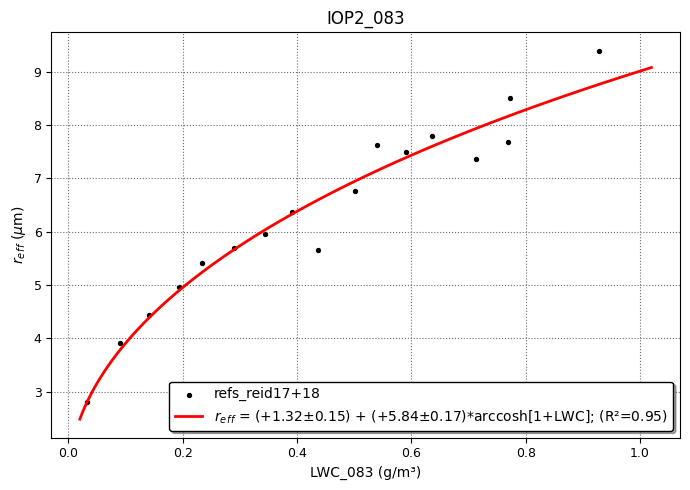

In [212]:
######################################################################### Ajuste:
x_datos = np.array(medianas_iop2['medianaslwc83'])
y_datos = np.array(medianas_iop2['medianasreff'])

### Equação da curva que será ajustada:
def modelo(x, a, b):
    return a+(b*np.arccosh(1+(x)))

### Parámetros iniciales con los que vamos a iniciar el proceso de fiteo:
parametros_iniciales=[1, 1]

### Fittando a curva:
popt, pcov = curve_fit(modelo, x_datos, y_datos, p0=parametros_iniciales)


#########################################################################  Fazendo o gráfico:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
tf = 14
ax.scatter(x_datos, y_datos, s=21, color='black', label='Medianas nos bins')

### Incerteza dos parâmetros ajustados:
nombres_de_param = ['a','b', 'c']
pstd = np.sqrt(np.diag(pcov))
for i, param in enumerate(popt):
    print('{:s} = {:5.3f} ± {:5.3f}'.format(nombres_de_param[i], param, pstd[i]/2))
ss_res = np.sum( (y_datos-modelo(x_datos,*popt))**2  )
ss_tot = np.sum( (y_datos-np.mean(y_datos))**2  )
### Cálculo do R²:
R2 = 1-(ss_res/ss_tot)
print('R2 = {:10.8f}'.format(R2))

x_modelo  = np.linspace(0.02, 1.02, 1000)
ax.plot(x_modelo, modelo(x_modelo, *popt), color='red', linewidth=2,
    label=u'$r_e$$_f$$_f$ = ({:+.2f}±{:.2f}) + ({:+.2f}±{:.2f})*arccosh[1+LWC]; (R²={:.2f})'.format(popt[0],
                                                                                                    pstd[0]/2,
                                                                                                    popt[1],
                                                                                                    pstd[1]/2,
                                                                                                    R2))
ax.legend(loc='lower right', ncol=1, fontsize=tf-3, fancybox='True', shadow='True', facecolor='white',
          edgecolor='black')
ax.grid(True, axis='both', zorder=0, linestyle='--', color='dimgray', linewidth=0.3)
ax.set_xlabel('LWC (g/m³)', fontsize=tf)
ax.set_ylabel('$r_e$$_f$$_f$ ($\mu$m)', fontsize=tf)
# ax.set_title("IOP2_083", fontsize=12)
ax.tick_params(labelsize=tf-1)
ax.set_ylim([0, 10])
ax.set_xlim([0.0, 1.0])
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

fig.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Dispersão_LWCXreff_Medianas_ArccosIOP1.png', 
#             dpi=400, bbox_inches='tight', facecolor='white')

a = 1.319 ± 0.153
b = 5.840 ± 0.169
R2 = 0.95194935


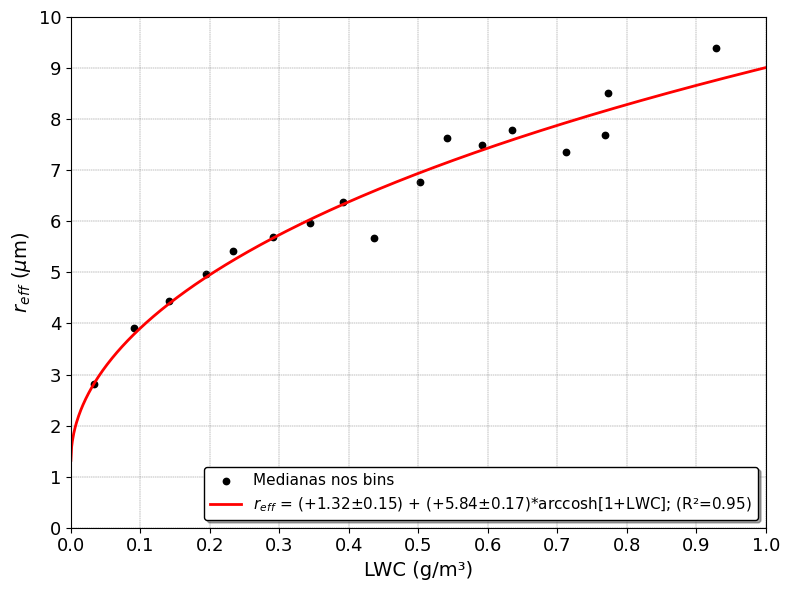

In [46]:
######################################################################### Ajuste:
x_datos = np.array(medianas_iop2['medianaslwc83'])
y_datos = np.array(medianas_iop2['medianasreff'])

### Equação da curva que será ajustada:
def modelo(x, a, b):
    return a+(b*np.arccosh(1+(x)))

### Parámetros iniciales con los que vamos a iniciar el proceso de fiteo:
parametros_iniciales=[1, 1]

### Fittando a curva:
popt, pcov = curve_fit(modelo, x_datos, y_datos, p0=parametros_iniciales)


#########################################################################  Fazendo o gráfico:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
tf = 14
ax.scatter(x_datos, y_datos, s=21, color='black', label='Medianas nos bins')

### Incerteza dos parâmetros ajustados:
nombres_de_param = ['a','b', 'c']
pstd = np.sqrt(np.diag(pcov))
for i, param in enumerate(popt):
    print('{:s} = {:5.3f} ± {:5.3f}'.format(nombres_de_param[i], param, pstd[i]/2))
ss_res = np.sum( (y_datos-modelo(x_datos,*popt))**2  )
ss_tot = np.sum( (y_datos-np.mean(y_datos))**2  )
### Cálculo do R²:
R2 = 1-(ss_res/ss_tot)
print('R2 = {:10.8f}'.format(R2))

x_modelo  = np.linspace(0.0, 1.02, 1000)
ax.plot(x_modelo, modelo(x_modelo, *popt), color='red', linewidth=2,
    label=u'$r_e$$_f$$_f$ = ({:+.2f}±{:.2f}) + ({:+.2f}±{:.2f})*arccosh[1+LWC]; (R²={:.2f})'.format(popt[0],
                                                                                                    pstd[0]/2,
                                                                                                    popt[1],
                                                                                                    pstd[1]/2,
                                                                                                    R2))
ax.legend(loc='lower right', ncol=1, fontsize=tf-3, fancybox='True', shadow='True', facecolor='white',
          edgecolor='black')
ax.grid(True, axis='both', zorder=0, linestyle='--', color='dimgray', linewidth=0.3)
ax.set_xlabel('LWC (g/m³)', fontsize=tf)
ax.set_ylabel('$r_e$$_f$$_f$ ($\mu$m)', fontsize=tf)
# ax.set_title("IOP2_083", fontsize=12)
ax.tick_params(labelsize=tf-1)
ax.set_ylim([0, 10])
ax.set_xlim([0.0, 1.0])
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

fig.tight_layout()

plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Dispersão_LWCXreff_Medianas_ArccosIOP2.png', 
            dpi=400, bbox_inches='tight', facecolor='white')